In [1]:
# Probabilistic PCA en MNIST completo

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

In [6]:
# 1. Cargar datos y filtrar dígito
mnist = fetch_openml('mnist_784', version=1)
X = mnist.data.astype(np.float32)
y = mnist.target.astype(int)

In [ ]:
# Filtrar las clases
mask = (y==0) | (y==1)
X_digit = X[mask]

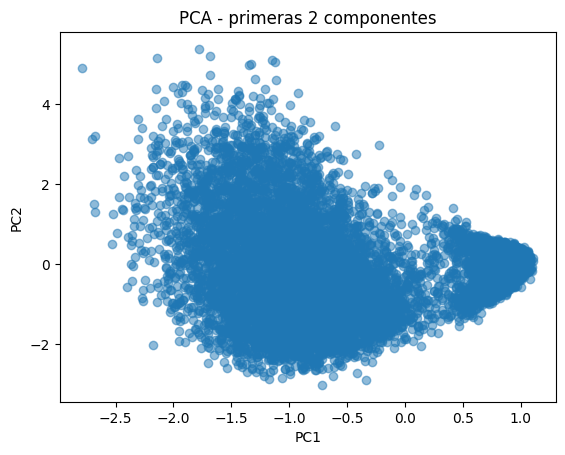

In [7]:
# 2. PCA estándar: visualización y reconstrucción
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_digit)

# PCA 2D para visualización
pca = PCA(n_components=2, whiten=True)
X_pca_2d = pca.fit_transform(X_scaled)

plt.figure()
plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], alpha=0.5)
plt.title("PCA - primeras 2 componentes")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [8]:
# Reconstrucción usando las primeras k componentes
k = 2
pca_k = PCA(n_components=k, whiten=True)
X_k = pca_k.fit_transform(X_scaled)
X_reconstructed = pca_k.inverse_transform(X_k)

# Cálculo del error de reconstrucción (MSE)
mse_pca = mean_squared_error(X_scaled, X_reconstructed)
print(f"Error cuadrático medio de reconstrucción (PCA k={k}): {mse_pca:.4f}")

Error cuadrático medio de reconstrucción (PCA k=2): 0.6097


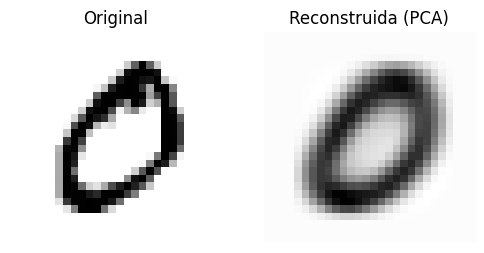

In [9]:
# Mostrar imagen original y reconstruida (PCA)
idx = 0
original_img = scaler.inverse_transform([X_scaled[idx]]).reshape(28, 28)
reconstructed_img = scaler.inverse_transform([X_reconstructed[idx]]).reshape(28, 28)

fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].imshow(original_img, cmap='gray_r')
axs[0].set_title("Original")
axs[1].imshow(reconstructed_img, cmap='gray_r')
axs[1].set_title("Reconstruida (PCA)")
for ax in axs:
    ax.axis('off')
plt.show()

In [10]:
# 3. PPCA manual según modelo probabilístico
D = X_scaled.shape[1]
M = 2

In [11]:
# Calcular matriz de covarianza
S = np.cov(X_scaled.T)

In [12]:
# Descomposición espectral
eigvals, eigvecs = np.linalg.eigh(S)
idx_sorted = np.argsort(eigvals)[::-1]
eigvals = eigvals[idx_sorted]
eigvecs = eigvecs[:, idx_sorted]

In [13]:
# σ^2 y W_ML
sigma2 = np.mean(eigvals[M:])
L_M = np.diag(eigvals[:M] - sigma2)
U_M = eigvecs[:, :M]
W_ml = U_M @ np.sqrt(L_M)

In [14]:
print(f'σ^2: {sigma2:.4f}')

σ^2: 0.6114


In [15]:
# Proyección al espacio latente y reconstrucción
M_mat = W_ml.T @ W_ml + sigma2 * np.eye(M)
Z_latent = np.linalg.solve(M_mat, W_ml.T @ X_scaled.T).T
X_ppca_reconstructed = Z_latent @ W_ml.T
mse_ppca = mean_squared_error(X_scaled, X_ppca_reconstructed)
print(f"Error cuadrático medio de reconstrucción (PPCA): {mse_ppca:.4f}")

Error cuadrático medio de reconstrucción (PPCA): 0.6098


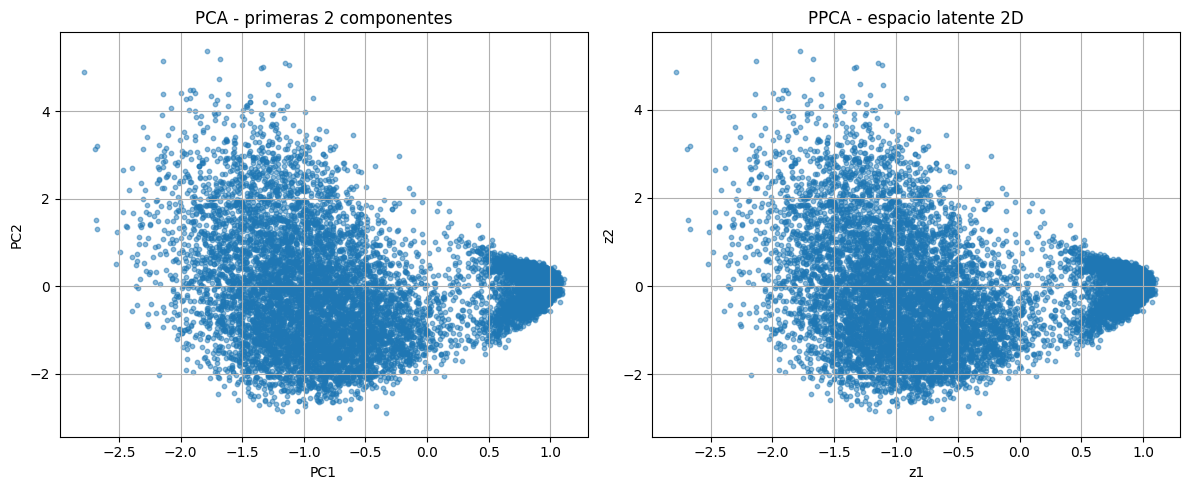

In [17]:
# Visualizar PCA y PPCA lado a lado
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], alpha=0.5, s=10)
axs[0].set_title("PCA - primeras 2 componentes")
axs[0].set_xlabel("PC1")
axs[0].set_ylabel("PC2")
axs[0].grid(True)

axs[1].scatter(Z_latent[:, 0], Z_latent[:, 1], alpha=0.5, s=10)
axs[1].set_title("PPCA - espacio latente 2D")
axs[1].set_xlabel("z1")
axs[1].set_ylabel("z2")
axs[1].grid(True)
plt.tight_layout()
plt.show()

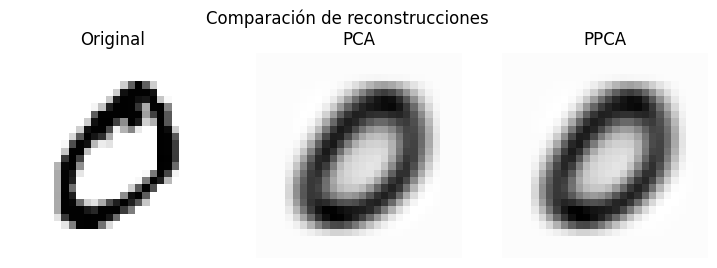

In [18]:
reconstructed_ppca_img = scaler.inverse_transform([X_ppca_reconstructed[idx]]).reshape(28, 28)

# Comparación visual de reconstrucciones
fig, axs = plt.subplots(1, 3, figsize=(9, 3))
axs[0].imshow(original_img, cmap='gray_r')
axs[0].set_title("Original")
axs[1].imshow(reconstructed_img, cmap='gray_r')
axs[1].set_title("PCA")
axs[2].imshow(reconstructed_ppca_img, cmap='gray_r')
axs[2].set_title("PPCA")
for ax in axs:
    ax.axis('off')
plt.suptitle("Comparación de reconstrucciones")
plt.show()

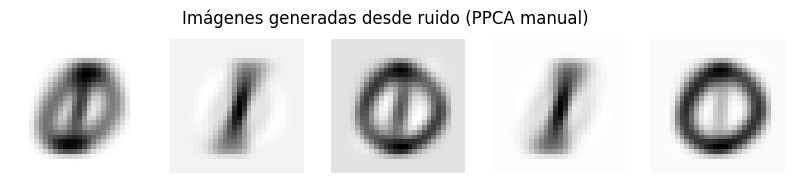

In [22]:
# 4. Generación desde ruido
num_samples = 5
z_samples = np.random.randn(num_samples, M)
x_gen_scaled = z_samples @ W_ml.T
x_gen = scaler.inverse_transform(x_gen_scaled).reshape(num_samples, 28, 28)

fig, axs = plt.subplots(1, num_samples, figsize=(num_samples * 2, 2))
for i in range(num_samples):
    axs[i].imshow(x_gen[i], cmap='gray_r')
    axs[i].axis('off')
plt.suptitle('Imágenes generadas desde ruido (PPCA manual)')
plt.show()